# Présentation du projet : 

## Contexte 

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


## Données 

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

## Mission

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

*La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.*


# Ressources : 

## Les données et leur description :

Site d'Olist (en portugais) : https://olist.com/

Adresse des données : https://www.kaggle.com/olistbr/brazilian-ecommerce

Convention PEP8 : https://www.python.org/dev/peps/pep-0008/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P4/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P4/"

## my .py : 
from script00_lists_of_vars import *
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import linear_model

from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fowlkes_mallows_score


# Première lecture des données :

In [2]:
product_category_name_translation = pd.read_csv(data_path 
                        + "product_category_name_translation.csv")
sellers = pd.read_csv(data_path + "olist_sellers_dataset.csv")
products = pd.read_csv(data_path + "olist_products_dataset.csv")
orders = pd.read_csv(data_path + "olist_orders_dataset.csv")
order_reviews = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")
order_payments = pd.read_csv(data_path + "olist_order_payments_dataset.csv")
order_items = pd.read_csv(data_path + "olist_order_items_dataset.csv")
geolocation = pd.read_csv(data_path + "olist_geolocation_dataset.csv")
customers = pd.read_csv(data_path + "olist_customers_dataset.csv")


Je commence par regarder les liens entre les tables : 


![alt text][link_image]

[//]: # (Image References)
[link_image]:kaggle_graph_link_datasets.png "table link kaggle" 



# 1 Table des clients 

Ce qui nous intéresse est une classification des clients : commençons donc par explorer cette table seule. 

In [3]:
print("shape : ", customers.shape)
print("number of NaNs :",customers.isna().sum().sum(),"\n")
print(customers.info())
customers.head(2)

shape :  (99441, 5)
number of NaNs : 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


Il y a donc au total {{customers.shape[0]}} commandes, passées par  {{len(customers["customer_unique_id"].value_counts())}} clients différents. Cette table donne également 3 informations sur la localisation du client (zip code, city, state), contenues dans des variables catégorielles.

Petite vérification : Est-ce que les "customer_unique_id" ont bien tous une adresse unique ? 

In [4]:
unique_id = customers.iloc[:,1:]#["customer_unique_id"]
unique_id = unique_id.drop_duplicates(ignore_index = False)
unique_id = unique_id["customer_unique_id"]
customer_id_non_unique = unique_id.value_counts()>1
customer_id_non_unique = unique_id.value_counts()[customer_id_non_unique]
customer_id_non_unique = customer_id_non_unique.index
customer_id_non_unique = unique_id.isin(customer_id_non_unique)
customer_id_non_unique = unique_id[customer_id_non_unique].index
customers_non_unique_commande = customers.loc[customer_id_non_unique]
customers_non_unique_commande.sort_values(by="customer_unique_id").head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
87012,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,maceio,AL
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL
61403,f530197ea86ced9488a03d055e118ebf,0058f300f57d7b93c477a131a59b36c3,40731,salvador,BA
36269,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,salvador,BA
54038,e024c1515b1062b1e7e613f840c35ba3,012452d40dafae4df401bced74cdb490,3984,sao paulo,SP
45307,f8e05a045de09e7855c9df3bb8815e0e,012452d40dafae4df401bced74cdb490,3220,sao paulo,SP
91727,483468a56a54dbbbf8f2b2354cc8a729,0178b244a5c281fb2ade54038dd4b161,12518,guaratingueta,SP
57218,ea6ba2b2e27f7efea73bdeab7fd6e4a0,0178b244a5c281fb2ade54038dd4b161,14960,novo horizonte,SP
82312,026ca919d538ee454a6d43fc8bd01de0,018b5a7502c30eb5f230f1b4eb23a156,74936,aparecida de goiania,GO
64800,b98e0d5aca458a26a6ff30fee0416ca2,018b5a7502c30eb5f230f1b4eb23a156,74976,aparecida de goiania,GO


Visiblement non ! Je pense qu'il sera donc préférable d'utiliser la table ```geolocation``` pour accéder à ces information. Vérifions si cette table est plus propre : 

In [5]:
print("\t Value counts of city for zip code = 71065: \n",
    geolocation.loc[geolocation["geolocation_zip_code_prefix"] == 71065,
                    "geolocation_city"].value_counts())
print("\n\t Firsts 5 value counts of zip codes for city = maceio: \n",
      geolocation.loc[geolocation["geolocation_city"] == "maceio",
                      "geolocation_zip_code_prefix"].value_counts()[:5])

print("\n\t geolocation dataframe head :")
geolocation.head(2)

	 Value counts of city for zip code = 71065: 
 brasilia    75
brasília    10
guara        6
Name: geolocation_city, dtype: int64

	 Firsts 5 value counts of zip codes for city = maceio: 
 57035    400
57036    123
57052     99
57025     75
57010     74
Name: geolocation_zip_code_prefix, dtype: int64

	 geolocation dataframe head :


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


Eh bien non ! Il va y avoir à faire un prétraitemement sur ces variables catégorielles. Il me semble que plusieurs options sont possibles :
* nettoyer les villes, donc nettoyage de texte, comme enlever les accents, les espaces en trop, les majuscules ...
* nettoyer les codes postaux : rassembler par ville ? 
* faire appel à la table ```geolocation``` pour utiliser les coordonnées géographiques des clients (latitude et longitude). 

Dans une première intention, je propose de n'utiliser que les codes postaux (zip code) comme proxy pour la localisation, ou même utiliser l'état de résidence (customer state). 

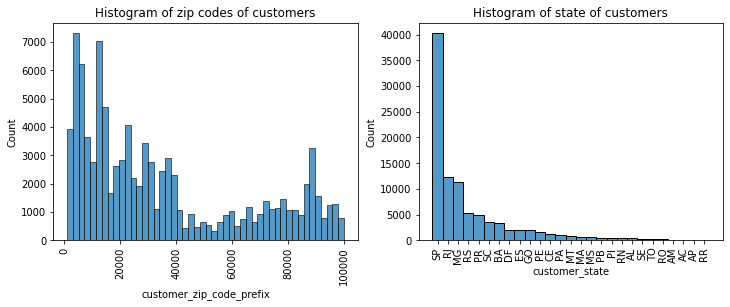

In [6]:
plt.figure(figsize=(12,4))
## removing duplicate customers (keep the 1st) :
tmp = customers.drop_duplicates(subset="customer_unique_id")

plt.subplot(1,2,1)
sns.histplot(tmp["customer_zip_code_prefix"])
plt.xticks(rotation=90)
plt.title("Histogram of zip codes of customers")

## sort by customer state values counts : 
dummy = tmp["customer_state"].value_counts().index
dummy = pd.Series(dummy, name = 'customer_state').to_frame()
tmp = pd.merge( tmp, dummy, on = "customer_state", how = 'right')

plt.subplot(1,2,2)
sns.histplot(tmp["customer_state"])
plt.xticks(rotation=90)
plt.title("Histogram of state of customers")
plt.show()

Une très grande majorité de clients sont dans l'état "SP" : a voir s'il on ne biaise pas les données en ne gardant que l'état. Les zip codes ont l'air répartis beaucoup plus homogènement, et me semblent donc à priori plus appropriés.


# 2 Table des commandes

## 2.1 Caractéristiques des commandes (orders)
Ensuite, nous cherchons à classifier les clients selon leur consommation : regardons donc l'échelle "commande".

In [7]:
print("shape : ", orders.shape)
print("number of NaNs :",orders.isna().sum().sum(),"\n")
print(orders.order_status.value_counts())
orders.head(3)

shape :  (99441, 8)
number of NaNs : 4908 

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Cette table regroupe les informations de status de la commande : la date et l'heure à laquelle elle a été passée, validée, expédiée, reçue. Elle contient aussi une variable de status qui me semble particulièrement intéressante. 

Pour les variables temporelles, je propose d'extraire plusieurs méta-variables :
* la date de commande seule
* l'heure de commande seule  
* la différence entre la date de livraison estimée et la date de livraison déclarée par le client (en jours)
* la différence entre la date de livraison déclarée par le client et la date de livraison déclarée par l'entreprise d'acheminement (en jours)

In [8]:
## Let's begin with purchase date and time split : 
purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp,
                     format = "%Y-%m-%d %H:%M:%S")

purchase_date = pd.to_datetime(purchase_timestamp.dt.date, 
                               format = "%Y-%m-%d")
purch_time = purchase_timestamp.dt.time 

In [9]:
## Then, use delta time for delivery date comparison
estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date,
                             format = "%Y-%m-%d %H:%M:%S")
delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date,
                             format = "%Y-%m-%d %H:%M:%S") 
delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date,
                             format = "%Y-%m-%d %H:%M:%S") 

delta_estimated_declared = estimated_delivery_date - delivered_customer_date
delta_estimated_declared = delta_estimated_declared / np.timedelta64(1, "D")

delta_decalared_customer_carrier = delivered_customer_date - delivered_carrier_date
delta_decalared_customer_carrier = delta_decalared_customer_carrier / np.timedelta64(1, "D")

In [10]:
## save in a working pd.DataFrame : 
my_orders = orders[['order_id', 'customer_id', 'order_status']].copy()
my_orders.at[:,"order_purchase_date"] = purchase_date
my_orders.at[:,"order_purchase_time"] = purch_time
my_orders.at[:,"order_dt_estimated_declared"] = delta_estimated_declared
my_orders.at[:,"order_dt_decalared_customer_carrier"] = delta_decalared_customer_carrier
my_orders.head(3)

,order_id,customer_id,order_status,order_purchase_date,order_purchase_time,order_dt_estimated_declared,order_dt_decalared_customer_carrier
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,10:56:33,7.107488,6.062650
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,20:41:37,5.355729,12.039410
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,08:38:49,17.245498,9.178113


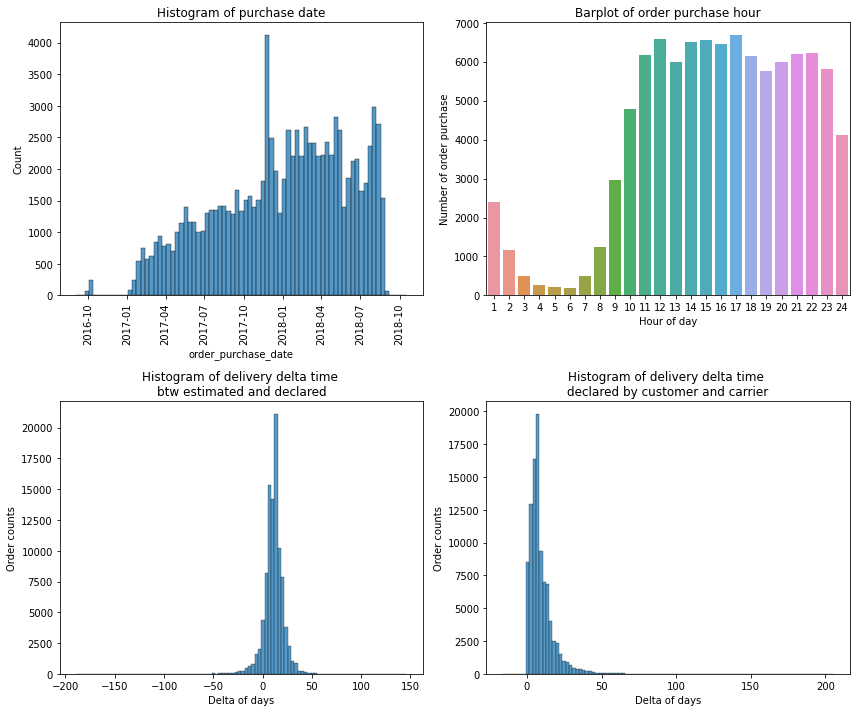

In [11]:
## Check with graphics :

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(my_orders.order_purchase_date)
plt.xticks(rotation=90)
plt.title("Histogram of purchase date")

plt.subplot(2,2,2)
tmp = pd.to_datetime(my_orders.order_purchase_time,  format = "%H:%M:%S")
tmp.groupby(tmp.dt.hour).count()
sns.barplot(x = np.arange(1,25), 
            y = tmp.groupby(tmp.dt.hour).count())
plt.title("Barplot of order purchase hour")
plt.xlabel("Hour of day")
plt.ylabel("Number of order purchase")

plt.subplot(2,2,3)
sns.histplot(my_orders.order_dt_estimated_declared, bins = 100)
plt.title("Histogram of delivery delta time \nbtw estimated and declared")
plt.xlabel("Delta of days")
plt.ylabel("Order counts")

plt.subplot(2,2,4)
sns.histplot(my_orders.order_dt_decalared_customer_carrier, bins = 100)
plt.title("Histogram of delivery delta time \ndeclared by customer and carrier")
plt.xlabel("Delta of days")
plt.ylabel("Order counts")

plt.tight_layout()
plt.show()


## TODO : Description des graphes 

## 2.2 Table des produits commandés (order_items)

Passons maintenant à l'étude de la table des produits commandés : 

In [12]:
print("shape : ", order_items.shape)
print("number of NaNs :",order_items.isna().sum().sum(),"\n")

order_items.head(3)

shape :  (112650, 7)
number of NaNs : 0 



,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


Cette table contient la liste des produits commandés dans différentes commandes, avec leur prix et la date limite d'envoi. La colonne "order_item_id" correspond au numéro attribué à l'article dans la commande. Est-ce que les mêmes articles sont vendus à des prix différents sur cette plateforme de vente ?

In [13]:
duplicates = order_items[order_items.duplicated(subset = "product_id", keep = False)]
duplicates = duplicates.sort_values("product_id")
duplicates.drop_duplicates(["product_id", "price"])
print("shape of duplicates after removes those with same price and name:",duplicates.shape)
duplicates.drop_duplicates(["product_id"])
print("shape of duplicates after removes those with same name :",duplicates.shape)

shape of duplicates after removes those with same price and name: (94533, 7)
shape of duplicates after removes those with same name : (94533, 7)


Il semblerait que oui. A quoi ressemble la répartition des prix ? 

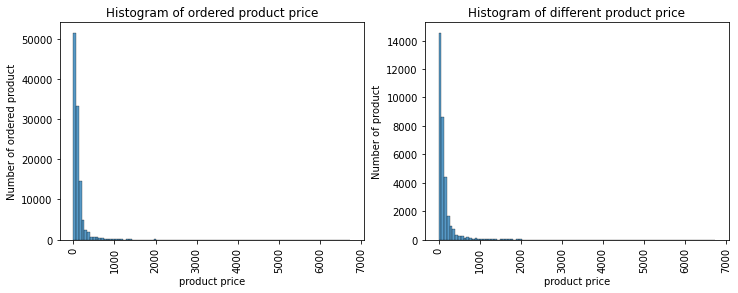

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(order_items.price, bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of ordered product price")
plt.xlabel("product price")
plt.ylabel("Number of ordered product")

plt.subplot(1,2,2)
sns.histplot(order_items.drop_duplicates(subset="product_id").price, bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of different product price")
plt.xlabel("product price")
plt.ylabel("Number of product")
plt.show()

On ne voit pas grand chose : passons en échelle log.

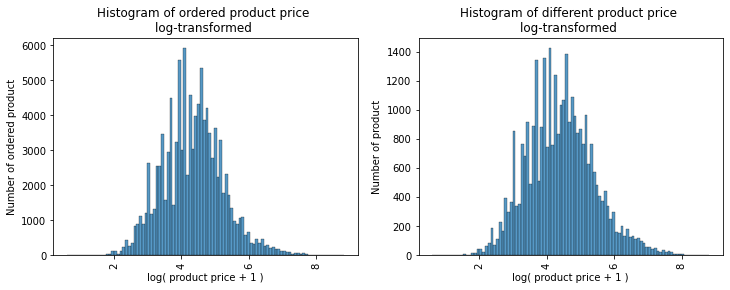

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(np.log(order_items.price+1), bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of ordered product price \nlog-transformed ")
plt.xlabel("log( product price + 1 )")
plt.ylabel("Number of ordered product")

plt.subplot(1,2,2)
sns.histplot(np.log(order_items.drop_duplicates("product_id").price
                    +1), bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of different product price \nlog-transformed ")
plt.xlabel("log( product price + 1 )")
plt.ylabel("Number of product")
plt.show()

Les commandes avec plusieurs items n'ont pas l'air de contenir des items moins cher. Regardons la répartition du prix total de chaque commande, ainsi que le fret associé :  

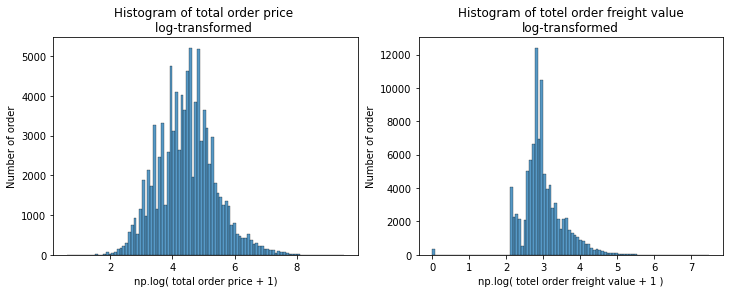

In [16]:
tmp = order_items.groupby("order_id").sum()
order_total_prices = pd.DataFrame(tmp.values, 
                                  columns = tmp.columns)
order_total_prices.at[:,"order_id"] = tmp.index

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(np.log( order_total_prices.price + 1 ), bins = 100)
plt.title("Histogram of total order price \nlog-transformed ")
plt.xlabel("np.log( total order price + 1)")
plt.ylabel("Number of order")

plt.subplot(1,2,2)
sns.histplot(np.log(order_total_prices.freight_value + 1 ), bins = 100)
plt.title("Histogram of totel order freight value\nlog-transformed")
plt.xlabel("np.log( totel order freight value + 1 )")
plt.ylabel("Number of order")
plt.show()

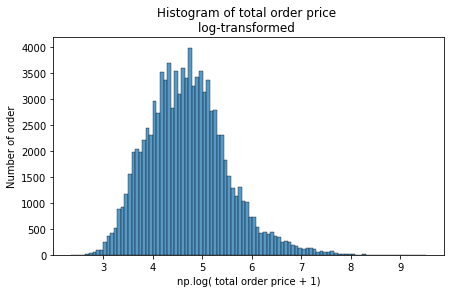

In [17]:
order_total_prices.at[:,"total"] = order_total_prices[["price","freight_value"]].sum(axis=1)

plt.figure(figsize=(7,4))
sns.histplot(np.log( order_total_prices.total + 1 ), bins = 100)
plt.title("Histogram of total order price \nlog-transformed ")
plt.xlabel("np.log( total order price + 1)")
plt.ylabel("Number of order")

plt.show()

Il n'y a rien d'inattendu : le prix des paniers en log-tranform a l'air répartis selon une loi normale. Pour le log du fret, on distingue 3 pics : un en 0, un en 2.3 et le troisième en 3.

In [18]:
my_orders = pd.merge(my_orders, order_total_prices[["order_id","price","freight_value"]], 
                     on = "order_id", how="left")
my_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_date',
       'order_purchase_time', 'order_dt_estimated_declared',
       'order_dt_decalared_customer_carrier', 'price', 'freight_value'],
      dtype='object')

## 2.3 Table des paiments (order_payments)

In [19]:
print("shape : ", order_payments.shape)
print("number of NaNs :",order_payments.isna().sum().sum(),"\n")

order_payments.head(3)

shape :  (103886, 5)
number of NaNs : 0 



,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


Les 4 colonnes de cette table semblent pertinentes. Il y a trois variables correspondant au moyen de paiement (type de paiement, nombre d'échéance de paiement choisis, et nombre de type de paiement), et la dernière variable est le prix payé (à comparer avec la variable "price", calculée en faisant la somme des prix de la table "order_items")

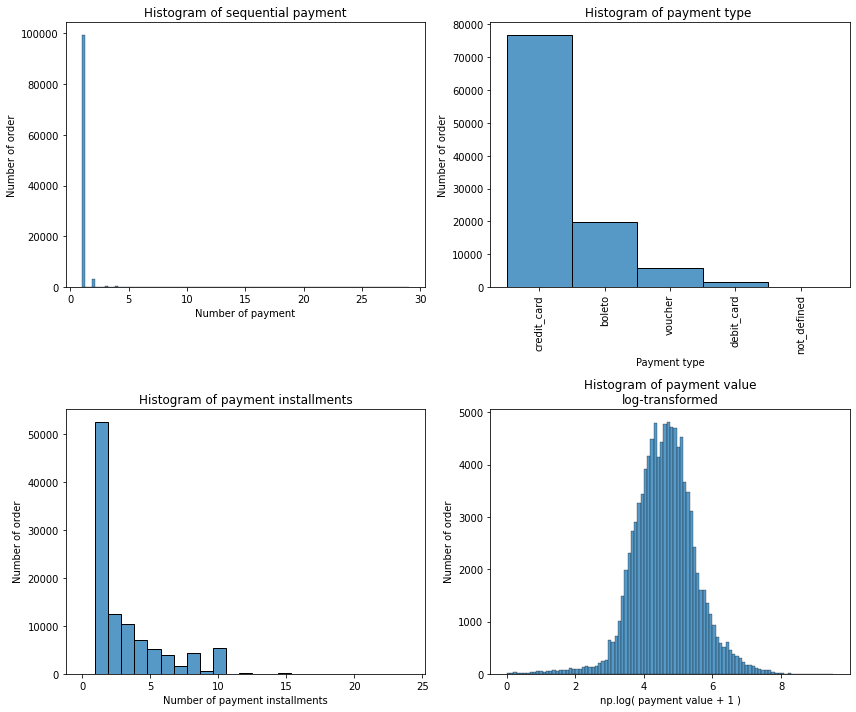

In [20]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(order_payments.payment_sequential, bins = 100)
plt.title("Histogram of sequential payment")
plt.xlabel("Number of payment")
plt.ylabel("Number of order")

plt.subplot(2,2,2)
sns.histplot(order_payments.payment_type)
plt.xticks(rotation=90)
plt.title("Histogram of payment type ")
plt.xlabel("Payment type")
plt.ylabel("Number of order")

plt.subplot(2,2,3)
sns.histplot(order_payments.payment_installments, bins = 25)
plt.title("Histogram of payment installments")
plt.xlabel("Number of payment installments")
plt.ylabel("Number of order")

plt.subplot(2,2,4)
sns.histplot(np.log(order_payments.payment_value + 1 ), bins = 100)
plt.title("Histogram of payment value\nlog-transformed")
plt.xlabel("np.log( payment value + 1 )")
plt.ylabel("Number of order")

plt.tight_layout()
plt.show()

Let us now just compare the order_payments.payment_value with the order_total_prices.total

In [21]:
sum_payments_order = order_payments[["order_id",
                "payment_value"]].groupby("order_id").sum().reset_index()
tmp = pd.merge(sum_payments_order,
         order_total_prices[["order_id","total"]], on="order_id")
index_diff_non_null = np.where(abs(tmp[["payment_value",
                            "total"]].diff(axis = 1))>10**-2)[0]
print(len(index_diff_non_null),"anomalies")
tmp.iloc[index_diff_non_null].head(3)

387 anomalies


,order_id,payment_value,total
165,00789ce015e7e5791c7914f32bb4fad4,190.81,168.83
525,016726239765c18f66826453f39c64e3,265.77,235.13
724,01e51b7c3025655646143d09b911e1d7,35.02,33.10


C'est assez étrange que les tables ne matchent pas. Il faudra faire attention à cela/demander au client si cela est normal. 

Ajoutons donc à la table d'exploitation ce qu'il semble pertinent d'extraire de cette table de paiements : 
* le nombre d'échelon de paiement 
* le type de paiement utilisé pour la majorité des payments (en terme de prix, "payment_type"). J'ai aussi regardé en terme de nombre de paiement, et en terme du plus gros paiment, les variables semblent presque identiques. 
* le nombre de type de paiement pour la commande

In [22]:
## payment_installments :
tmp = order_payments.sort_values("payment_installments",ascending=False).drop_duplicates("order_id","first")
my_orders = pd.merge(my_orders, tmp[["order_id","payment_installments"]], 
                     on="order_id", how="left")

In [23]:
# ## most frequent payment type :
# tmp = order_payments[["order_id", "payment_type"]].sort_values(by = "order_id")#"payment_type")
# tmp = pd.DataFrame(tmp.value_counts().reset_index())
# tmp = tmp.drop_duplicates("order_id")[["order_id", "payment_type"]]
# my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

In [24]:
# ## higher payment type :
# tmp = order_payments.sort_values("payment_value",
#                   ascending=False).drop_duplicates("order_id","first")
# tmp = tmp.rename(columns={"payment_type":"higher_payment_type"})
# my_orders = pd.merge(my_orders, tmp[["order_id","higher_payment_type"]], 
#                     on="order_id", how="left")

In [25]:
## most of payment type (max sum of value): 
## extract sum of payment value for each payment type : 
sub_table = order_payments[["order_id","payment_value","payment_type"]]
sub_table = sub_table.sort_values("order_id")
index = sub_table.drop_duplicates(["order_id","payment_type"]).index

tmp = sub_table.groupby(["order_id","payment_type"]).sum()
tmp = tmp.reset_index().set_index(index)

## drop duplicates where smaller payment_values (sum)
tmp = tmp.sort_values("payment_value", ascending=False)
tmp = tmp.drop_duplicates("order_id", keep="first")
my_orders = pd.merge(my_orders, tmp[["order_id","payment_type"]],
                     on="order_id", how="left")

In [26]:
## number of payment type : 
tmp = order_payments[["order_id","payment_type"]].drop_duplicates()
tmp = tmp["order_id"].value_counts().reset_index()
tmp = tmp.rename(columns={"index":"order_id", 
                          "order_id":"nb_payment_type"})
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

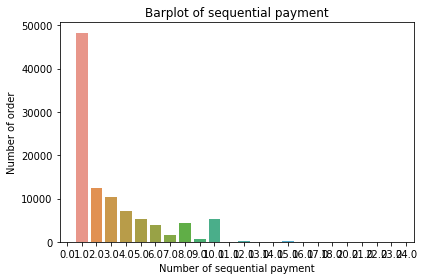

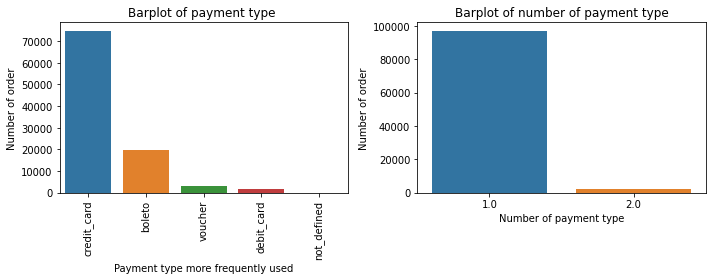

In [27]:
## graphics : 
plt.figure(figsize=(6,4))

tmp = my_orders.payment_installments.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Barplot of sequential payment")
plt.xlabel("Number of sequential payment")
plt.ylabel("Number of order")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
tmp = my_orders.payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.xticks(rotation=90)
plt.title("Barplot of payment type ")
plt.xlabel("Payment type more frequently used")
plt.ylabel("Number of order")

plt.subplot(1,2,2)
tmp = my_orders.nb_payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Barplot of number of payment type")
plt.xlabel("Number of payment type")
plt.ylabel("Number of order")

plt.tight_layout()
plt.show()

## 2.4 Table des paiments (order_reviews)

In [28]:
print("shape : ", order_reviews.shape)
print("number of NaNs :",order_reviews.isna().sum().sum(),"\n")

order_reviews.head(3)

shape :  (100000, 7)
number of NaNs : 146532 



,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


Il y a un très grand nombre de valeurs manquantes : 

In [29]:
order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Ces valeurs manquantes sont dans les parties textuelles des commentaires (title et message). La deuxième chose marquante dans cette table est la dimension. Est ce qu'une même commande a des scores différents ? 

In [30]:
## number of different score for one order : 
tmp = order_reviews[["order_id","review_score"]].drop_duplicates()
tmp = tmp["order_id"].value_counts()
print("there are ", sum(tmp>1), "orders with different scores")

tmp = order_reviews[["order_id","review_score"]]
tmp = tmp.value_counts()
tmp = pd.Series(tmp.groupby("order_id").count(),
                   name="count_change_scores")
tmp = tmp.reset_index()
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

there are  209 orders with different scores


In [31]:
## mean score for one order : 
tmp = order_reviews.groupby("order_id").mean().reset_index()
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

In [32]:
## add count_reviews, count_messages, count_title, for one order : 
tmp = order_reviews.groupby("order_id").count().reset_index()
tmp = tmp[["order_id","review_id", "review_comment_title", "review_comment_message"]]

dict_rename = {"review_id":"count_review"}
for colname in tmp.columns[2:] :
    new_colname = "count"
    for str1 in colname.split("_")[1:] : 
        new_colname = str(new_colname+"_"+str1)
    dict_rename[colname]=new_colname
    
tmp = tmp.rename(columns=dict_rename)
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

Possible amélioration : 
* regarder dans les messages de review pourquoi les clients sont satisfaits/non satisfaits
* prendre en compte la temporalité des commentaires


# 3 Les produits

Il va y avoir un certain travail à faire sur les produits, car c'est une échelle plus petite (plusieurs produits par commande) et il va falloir résumer les informations de cette très grande table pour en faire quelques colonnes dans la table my_orders.

## 3.1 La table des produits : 

In [33]:
print("shape : ", products.shape)
print("number of NaNs :",products.isna().sum().sum(),"\n")

# print(products.isna().sum())
products.head(3)

shape :  (32951, 9)
number of NaNs : 2448 



,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


Je propose d'utiliser une NMF sur les produits, afin de chercher à les regrouper en des sens sémantiques, et utiliser ce réduction de dimension pour qualifier les paniers : est ce que les produits achetés sont des hauts de gamme ? est ce qu'il s'agit de biens de consommation ? La constitution du panier est-il homogène ou hétérogène ? 

Pour choisir les paramètre de réduction de dimension qui correspondent le mieux à l'utilisation, je propose de l'utiliser pour prédire la catégorie du produit. 

In [34]:
## extract numeric table with id as index
X = products.copy()

X = X.set_index("product_id")
y = X["product_category_name"]
## soit fillna soit drop les produits
y = y.fillna("missing")
# missing_index = y[y.isna()].index
# y = y.drop(index=missing_index)
# X = X.drop(index=missing_index)
X = X.loc[:,~(X.dtypes == object)]
y = y.astype("category")

n_clusters = len(np.unique(y))
X.shape

(32951, 7)

Pour utiliser les pipelines de sklearn, j'ai besoin de n'avoir aucune valeur manquante. Je vais donc imputer les valeurs manquantes numériques par un algorithme des plus proches voisins, les valeurs manquantes catégorielles sont remplacées par une nouvelle catégorie 'missing'.

MSE = 363.840 (+/-5.289) for {'n_neighbors': 1}
MSE = 312.258 (+/-2.723) for {'n_neighbors': 2}
MSE = 293.258 (+/-2.890) for {'n_neighbors': 3}
MSE = 284.657 (+/-4.534) for {'n_neighbors': 4}
MSE = 278.012 (+/-3.873) for {'n_neighbors': 5}
MSE = 273.478 (+/-3.539) for {'n_neighbors': 6}
MSE = 270.014 (+/-3.446) for {'n_neighbors': 7}
MSE = 267.433 (+/-3.007) for {'n_neighbors': 8}
MSE = 265.345 (+/-2.872) for {'n_neighbors': 9}
MSE = 263.750 (+/-2.756) for {'n_neighbors': 10}
MSE = 262.441 (+/-2.686) for {'n_neighbors': 11}
MSE = 261.276 (+/-2.720) for {'n_neighbors': 12}
MSE = 260.375 (+/-2.538) for {'n_neighbors': 13}
MSE = 259.540 (+/-2.522) for {'n_neighbors': 14}


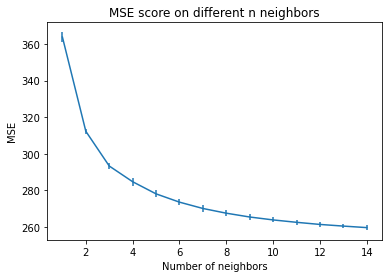

In [35]:
## Standardization for missing values imputation :
my_std = StandardScaler().fit(X)
X_std = pd.DataFrame(my_std.transform(X), 
                     columns=X.columns, index = X.index)

## missing values treatment : 
my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,15,1)}
cv = 4

# res = launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
## Save dictionnary of results : 
# with open(res_path+"set_n_KNN_impute_products"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"set_n_KNN_impute_products"+".pkl", "rb") as f :
        res = pickle.load(f)
fig_name = None
plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

n_neighbors = 10 
## Impute missing values :
imputer = KNNImputer(n_neighbors=n_neighbors)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = my_std.inverse_transform(pred_std)
X = pd.DataFrame(pred, index = X.index, columns = X.columns)
X_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

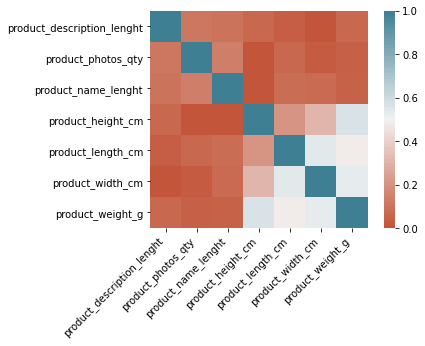

In [36]:
plot_heatmap_dist(X.corr())

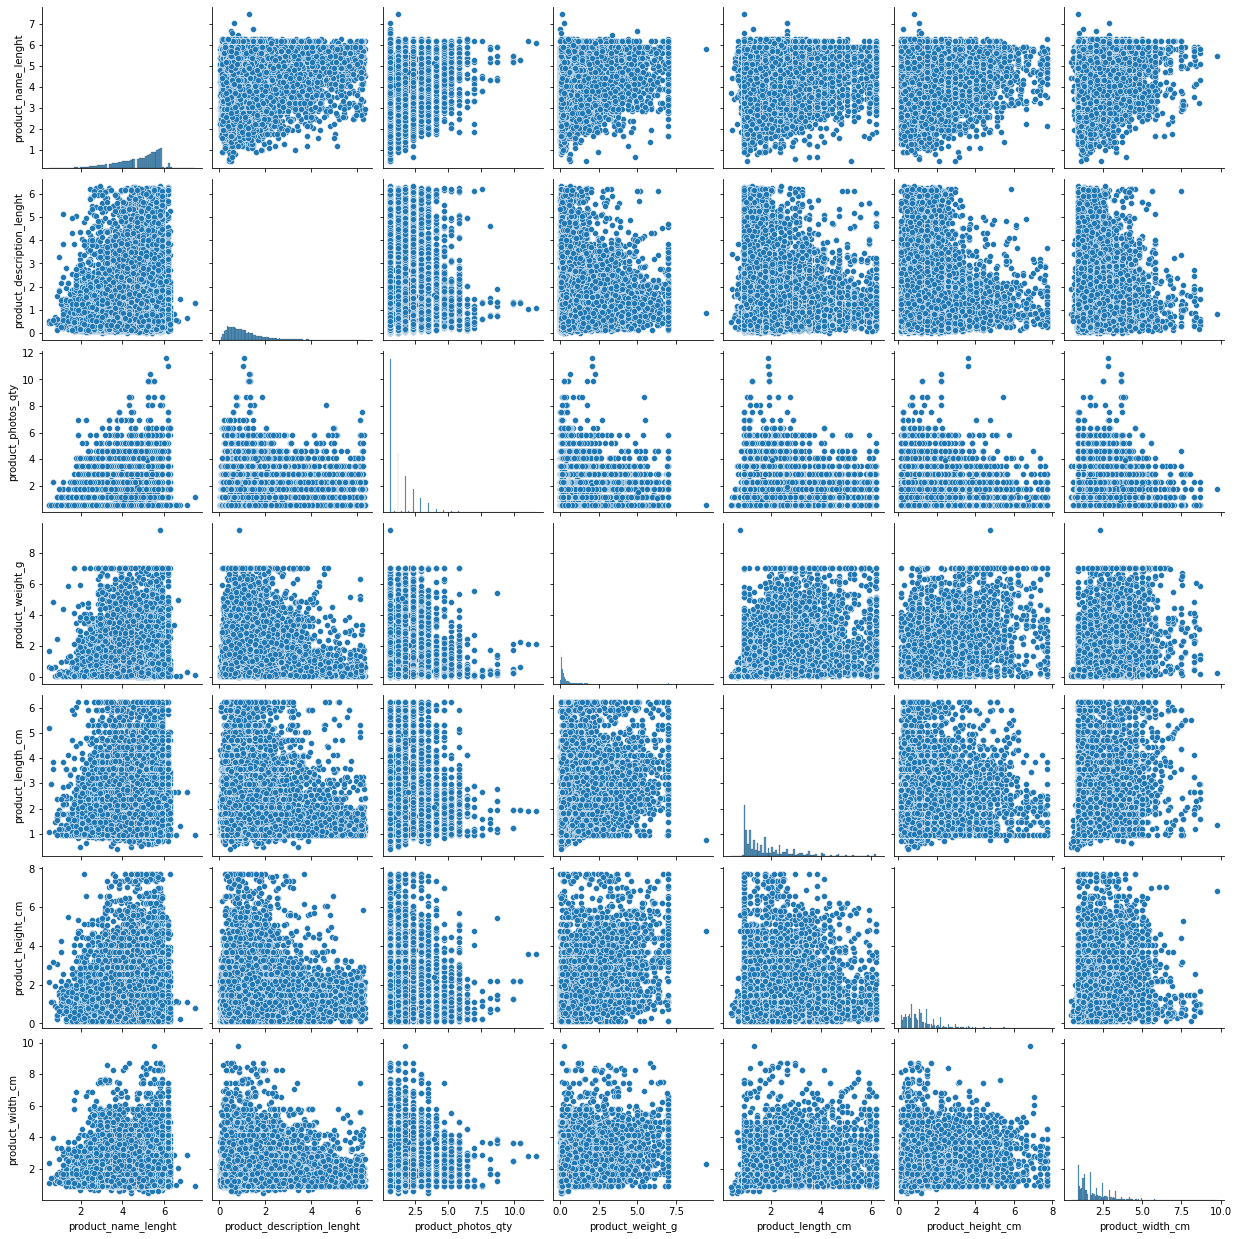

In [37]:
my_std2 = StandardScaler(with_mean = False)
X_std2 = pd.DataFrame(my_std2.fit_transform(X),
                      columns=X.columns, index=X.index) 
# tmp = pd.merge(y, X_std2, left_index=True, right_index=True)
sns.pairplot(X_std2)
plt.show()

### Réduction de dimension : 

Nous avons une classification (les catégories des produits), mais qui on l'air d'avoir un nombre très important de catégories (plus de 70). Je pense donc commence par faire une réduction de dimension (NMF et PCA) :

#### PCA

Je commence par la PCA : 

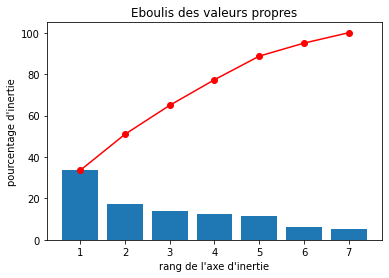

In [38]:
my_pca = PCA(n_components=X_std2.shape[1])
my_pca.fit(X_std2)
display_scree_plot(my_pca)

Les deux premiers axes de l'ACP  résument un peu plus de 50% de la variance. Ce n'est pas terrible. Essayons autre chose 

#### NMF

Quant à la NMF, il y a plusieurs hyperparamètres, mais il n'est pas possible de les choisir tel quel : il faudrait définir un score pour cela (je n'en trouve pas dans sklearn). Je réfléchis comment faire cela à partir de la norme de frobenius.


In [39]:
def frobenius_func(y, y_pred):
    return(np.linalg.norm(y-y_pred,"fro"))

def pseudo_cv_reduce_dim(X, my_meth, param_grid,my_score, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = 5)
    CV_split_iterator = kf.split(X_,y) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            W = my_meth.fit_transform(train)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(train, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

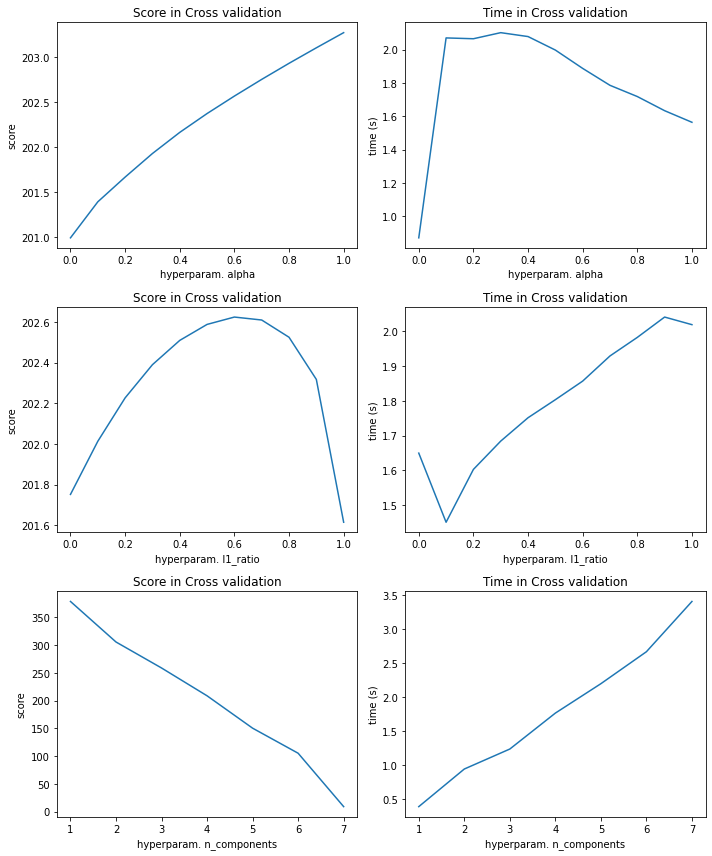

In [45]:
## should the plot be on logscale ?
dict_log_param = {"n_components" : False,
                  "alpha" : False,
                  "l1_ratio" : False,
                  "n_components" : False,
                  "classify__n_clusters" : False,
                  "classify__init" : False
                 }

## 1sr CV : 
param_grid = {'n_components': np.arange(1, X.shape[1]+1),
              'alpha': np.arange(0,1.1,0.1),
              'l1_ratio': np.arange(0,1.1,0.1)
             }
my_nmf = NMF(n_components=3, max_iter=1000, init ='nndsvdar')
my_score = frobenius_func
# res = pseudo_cv_reduce_dim(X_std2,my_nmf,param_grid, my_score, cv = 5)

# with open(res_path+"reduce_dim_products/NMF_res"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"reduce_dim_products/NMF_res"+".pkl", "rb") as f :
    res = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()


Même avec les meilleurs hyperparamètres (best_params = {"alpha" : 0.1, "l1_ratio" : 0.1}) cette réduction de dimension semble faire perdre beaucoup d'information :

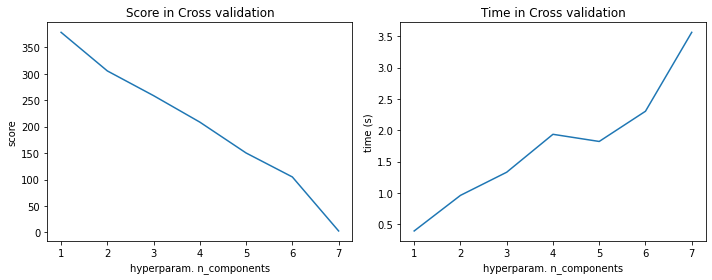

In [46]:
best_params = {"alpha" : 0.1, "l1_ratio" : 0.1}

## 1sr CV : 
param_grid = {'n_components': np.arange(1, X.shape[1]+1)}
my_nmf = NMF(max_iter=1000, init ='nndsvdar', **best_params)
my_score = frobenius_func
# res = pseudo_cv_reduce_dim(X_std2,my_nmf,param_grid, 
#                            my_score, cv = 5)

# with open(res_path+"reduce_dim_products/NMF_res_n_compo"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"reduce_dim_products/NMF_res_n_compo"+".pkl", "rb") as f :
    res = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()

Je vais donc comparer cette NMF avec une ACP

#### Etude de la réduction de dimension seule : 
Je propose de vérifier si ces projections sont sémantiques, en regardant la traduction des catégories de produit  : 

In [47]:
def plot_coeffs(my_meth, X_, X_name= "X"):
    '''
    from dim reduceur, plot coefficients of the 2 first axis
    and return coefficients on whole axis
    
    Parameters:
    -----------------------------------------
    my_meth = sklearn.decomposition methode like PCA of NMF 
    X_ = pd.DataFrame() of data to be reduced
    
    Returns:
    -----------------------------------------
    pd.DataFrame of coefficients
    '''
    my_meth.set_params(**{"n_components": X_.shape[1]})
    my_meth.fit(X_)

    coeffs = pd.DataFrame(my_meth.components_, columns = X_.columns,
                          index = ["ax_"+str(k) for k in np.arange(1,my_meth.n_components+1)])
    for colname in coeffs.columns :
        plt.scatter(x = coeffs.loc["ax_1", colname], 
                    y = coeffs.loc["ax_2", colname],
                    label = colname)
    plt.xlabel("coeff axis 1")
    plt.ylabel("coeff axis 2")
    my_meth_name = str(my_meth).split("(")[0]
    plt.title(my_meth_name+" on "+ str(X_name))

    plt.legend()
    return(coeffs)

Il y a donc deux colonnes qui résument presque à elles seules la table, il s'agit de la longeur de la description du produit et du poids.Je jette un coup d'oeil à l'ACP : 

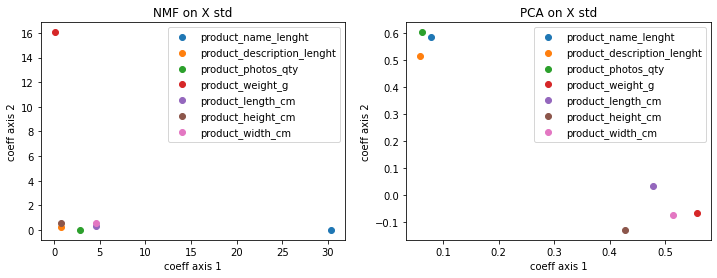

In [48]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
coeff_nmf = plot_coeffs(NMF(init = "random", max_iter = 10000,**best_params),X_std2, "X std")
plt.subplot(1,2,2)
coeffs_pca = plot_coeffs(PCA(),X_std2, "X std")
plt.show()

Le premier axe de la nmf est principalement constitué de la longueur du nom du produit, avec un poids 6 fois plus petit pour les autres variables. Le deuxième axe est tiré par la longueur du produit. Les autre colonnes ont des poids négligeables. 

L'ACP quant à elle regroupe les variables en deux catégories : 
* les dimensions du produit : longueur, largeur, hauteur, épaisseur. 
* les méta-données : la longueur du nom du produit, la longueur de la description, et la qualité de la photo

Lorsque les données sont réduite, on voit qu'il y avait clairement un effet d'échelle, c'était une bonne idée de réduire les données (X_std2)

Pour la suite, je propose de plutôt garder les résultats de l'ACP. En effet, je me rappelle bien qu'il faut un produit qui puisse être exploité par l'équipe marketing d'Olist, ainsi, je pense qu'il est pertinent de réduire la base de données "produit" avec l'ACP (car sémantique simple d'interprétation) pour permettre le traitement automatique de cette table. Par cela, j'entends lancer une ACP sur les deux groupe, pour avoir une projection à une dimension des variables "dimensions" et "description", et en faire deux variables sur lesquelles projeter les commandes.

In [49]:
def get_X_missing_vals_imputed(products, std = False):
    ## extract numeric table with id as index
    X = products.copy()
    X = X.set_index("product_id")
    X = X.loc[:,~(X.dtypes == object)]
    ## Standardize 
    my_std = StandardScaler().fit(X)
    X_std = pd.DataFrame(my_std.transform(X), columns=X.columns, index=X.index)
    n_neighbors = 10 
    ## Impute missing values :
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_std = imputer.fit_transform(X_std)
    X_std = pd.DataFrame(X_std, index = X.index, columns = X.columns)
    if std :
        return(X_std)
    else :
        ## Inverse-standardize : 
        X = my_std.inverse_transform(X_std)
        X = pd.DataFrame(X, index = X_std.index, columns = X_std.columns)
        return(X)


In [50]:
dimension_vars = ['product_weight_g', 'product_length_cm',       
                  'product_height_cm', 'product_width_cm']
description_vars = ['product_name_lenght', 'product_description_lenght',
                    'product_photos_qty']

def get_coeffs_project2d_products(products): 
    
    X_std = get_X_missing_vals_imputed(products, std = True)
    
    X_dimension = X_std.loc[:,dimension_vars]
    X_description = X_std.loc[:,description_vars]

    my_pca = PCA(n_components=1)
    my_pca.fit(X_dimension)
    dimension_coeffs = pd.Series(my_pca.components_[0], index = dimension_vars)
    my_pca.fit(X_description)
    description_coeffs = pd.Series(my_pca.components_[0], index = description_vars)
    return(dimension_coeffs, description_coeffs)

dimension_coeffs, description_coeffs = get_coeffs_project2d_products(products)

print(dimension_coeffs, "\n")
print(description_coeffs)

##TODO : coeffs to be revaluated every year, otherwize, use pre-computed coeffs
def project2d_products(products, coeffs, var) :
    dimension_coeffs, description_coeffs = coeffs
    dimension_vars, description_vars = var
    X_std = get_X_missing_vals_imputed(products, std = True)
    ## project on coeffs
    product_dimension = np.dot(X_std.loc[:,dimension_vars],dimension_coeffs)
    product_dimension = pd.Series(product_dimension, name="product_dimension",
                                 index = X_std.index)
    product_description = np.dot(X_std.loc[:,description_vars],description_coeffs)
    product_description = pd.Series(product_description, name="product_description",
                                 index = X_std.index)
    ## concat on index = product_id
    res = products.copy()
    res = res.set_index("product_id")
    res = pd.merge(res["product_category_name"], product_dimension, left_index=True, right_index=True)
    res = pd.merge(res, product_description, left_index=True, right_index=True)
    return(res)

coeffs = get_coeffs_project2d_products(products)
var = dimension_vars, description_vars
my_products = project2d_products(products, coeffs, var)

product_weight_g     0.560379
product_length_cm    0.478652
product_height_cm    0.433100
product_width_cm     0.518933
dtype: float64 

product_name_lenght           0.587492
product_description_lenght    0.537568
product_photos_qty            0.604875
dtype: float64


Ensuite, il y a un nombre trop grand de catégories de produits. Je propose de les regrouper un nombre plus restreint de méta-catégories pour limiter le fléau de la dimension, et faciliter l'interprétation.
### Clustering sur les catégories de produit 
#### Kmeans

Je commence par évaluer le nombre de cluster approprié par un kmeans. En effet, je pense qu'une première approche semi-suppervisée permet de voir comment bien résumer les 73 catégories (et voir si c'est pertinent de de le faire).

Je me suis en grande partie inspirée de ce code pour écrire ce qui suit : https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html



{'classify__init': 'k-means++', 'classify__n_clusters': 1}

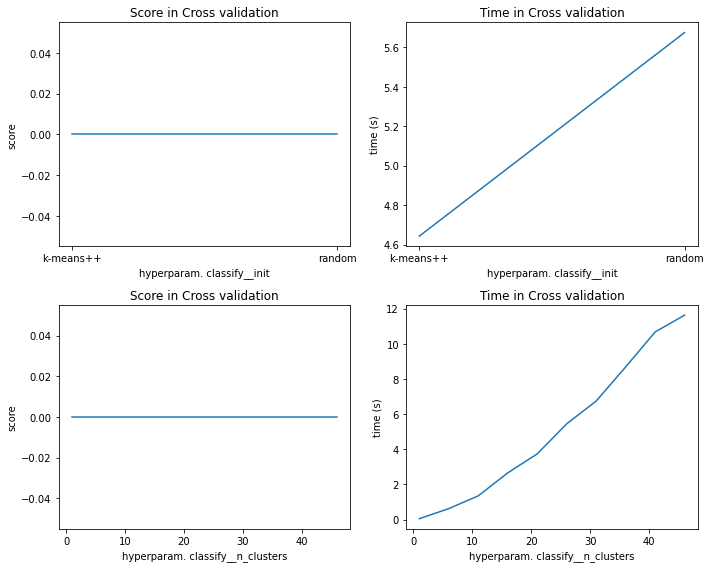

In [51]:
## 1st pipe - kmeans
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('classify', KMeans(n_clusters = 10, max_iter=1000))
    ])

param_grid = [{ 'classify__n_clusters': np.arange(1,50,5), 
                'classify__init':["k-means++","random"]}]

# grid = GridSearchCV(pipe1, param_grid = param_grid,
#                     n_jobs=5, cv = 5, scoring= "accuracy")
# grid.fit(X,y)
# ## Save dictionnary of results : 
# res = grid.cv_results_
# with open(res_path+"reduce_dim_products/kmeans_res_accuracy_y"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
# best_params = grid.best_params_
# with open(res_path+"reduce_dim_products/kmeans_best_params_accuracy_y"+".pkl", "wb") as f :
#     pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


with open(res_path+"reduce_dim_products/kmeans_res"+".pkl", "rb") as f :
    res = pickle.load(f)
with open(res_path+"reduce_dim_products/kmeans_best_params"+".pkl", "rb") as f :
    best_params = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()
best_params

Le score est nul ! J'essaie donc autrement (approche non supervisée, avec un score type "fowlkes_mallows_score")  

[0.337291   0.51016864]


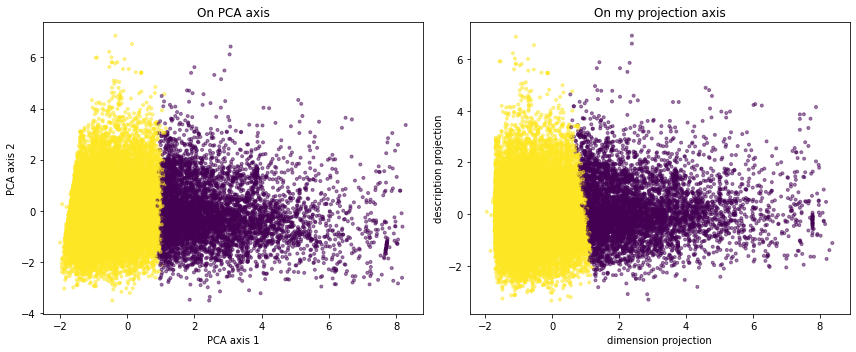

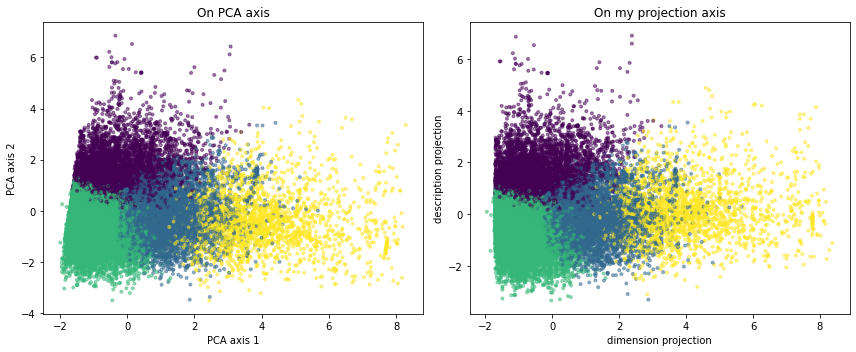

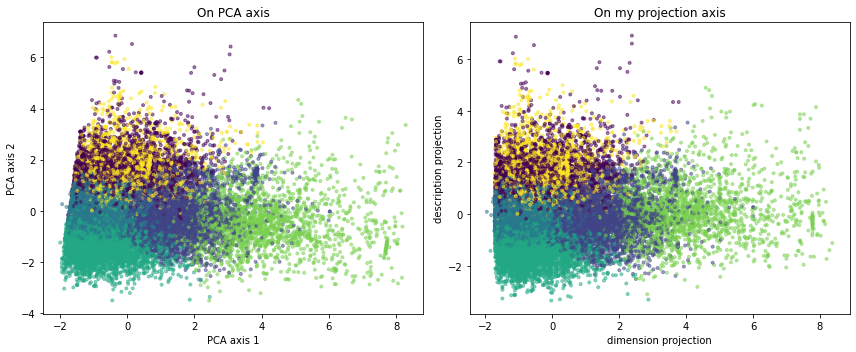

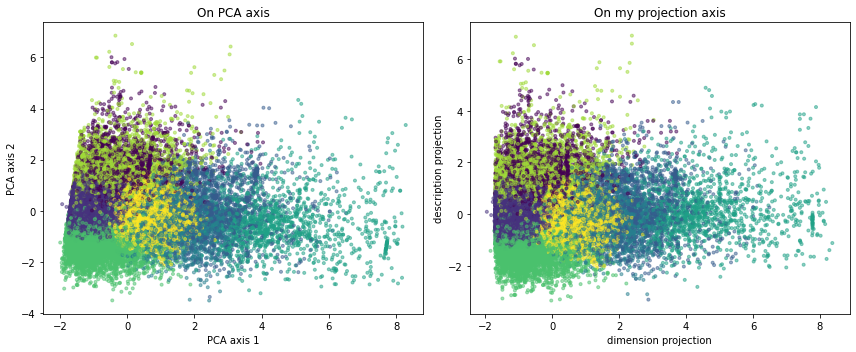

In [52]:

## 1st pipe - kmeans
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('classify', KMeans(n_clusters = 10, max_iter=1000))
#     ('2d_projection',  PCA(n_components=2))
    ])

## vizualization on PCA axis :
my_pca = PCA(n_components=2).fit(X_std)
print(my_pca.explained_variance_ratio_.cumsum())
X_proj = my_pca.transform(X_std)

for n_clusters in np.arange(2,10,2):
    pipe1.set_params(**{"classify__n_clusters" : n_clusters})
    pipe1.fit(X)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(x=X_proj[:,0], y=X_proj[:,1], 
                c=pipe1["classify"].labels_, alpha = 0.5, marker=".") 
    plt.title("On PCA axis")
    plt.xlabel("PCA axis 1")
    plt.ylabel("PCA axis 2")

    plt.subplot(1,2,2)
    plt.scatter(x=my_products["product_dimension"], y=my_products["product_description"],
                c=pipe1["classify"].labels_, alpha = 0.5, marker=".") 
    plt.title("On my projection axis")
    plt.xlabel("dimension projection")
    plt.ylabel("description projection")
    plt.tight_layout()
    plt.show()
# ## vizualization on PCA axis :
# for n_clusters in np.arange(3,8):
#     pipe1.set_params(**{"classify__n_clusters" : n_clusters})
#     pipe1.fit(X)
#     X_proj = pipe1.transform(X)
#     plt.scatter(x=X_proj[:,0], y=X_proj[:,1], c=pipe1["classify"].labels_, alpha = 0.5, marker=".") 
#     # ["cluster"+str(k) for k in np.arange(1,n_clusters+1)]
#     plt.show()

Le problème est qu'il est alors très compliqué d'avoir un score pertinent pour choisir le nombre de cluster. D'autant que les catégories ne sont peut-être pas du tout caractérisées par les autres informations de cette table "products". Il serait donc sûrement intéressant de regrouper les catégories autrement, à méditer ##TODO

idée 1 : en regardant à l'échelle des commandes : si cat1 et cat2 souvent dans le même panier, je regroupe.

Je vais donc retourner à l'échelle "commande", où il me reste tables à exploiter. Pour rappel, mon aggrégation des tables ressemble actuellement à ça : 


In [53]:
my_orders.head(3)

,order_id,customer_id,order_status,order_purchase_date,order_purchase_time,order_dt_estimated_declared,order_dt_decalared_customer_carrier,price,freight_value,payment_installments,payment_type,nb_payment_type,count_change_scores,review_score,count_review,count_comment_title,count_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,10:56:33,7.107488,6.062650,29.99,8.72,1.0,voucher,2.0,1,4.0,1,0,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,20:41:37,5.355729,12.039410,118.70,22.76,1.0,boleto,1.0,1,4.0,1,1,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,08:38:49,17.245498,9.178113,159.90,19.22,3.0,credit_card,1.0,1,5.0,1,0,0


## 3.2 Produit dans les commandes :

### Étude descriptive

Pour rappel, j'ai déjà extrait les information de la table "order_items", telles que le prix. Je fais de nouveau appel à cette table uniquement pour faire le lien entre produit et commande. 
Déjà, combien y-a-t'il d'articles différents dans chaque commande ? 

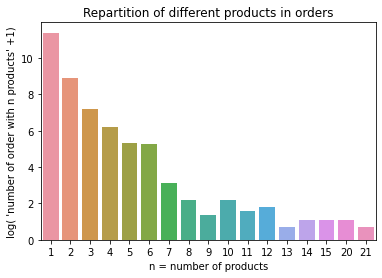

In [54]:
# tmp = order_items.order_id.value_counts()[(order_items.order_id.value_counts()>1).values]
tmp = order_items.order_id.value_counts().value_counts()
sns.barplot(x=tmp.index, y=np.log(tmp.values+1))
plt.title("Repartition of different products in orders")
plt.xlabel("n = number of products")
plt.ylabel("log( 'number of order with n products' +1)")
plt.show()
# 98666 == np.unique(order_items.order_id).shape[0]

Il y a au plus {{max(tmp.index)}} produits dans chaque commande, et une majorité de commande n'a qu'un seul produit ({{np.round(tmp[1]/order_items.shape[0]*100,1)}} % des commandes).

Et comment se répartit le nombre d'apparition des produits dans les différentes commandes ? 

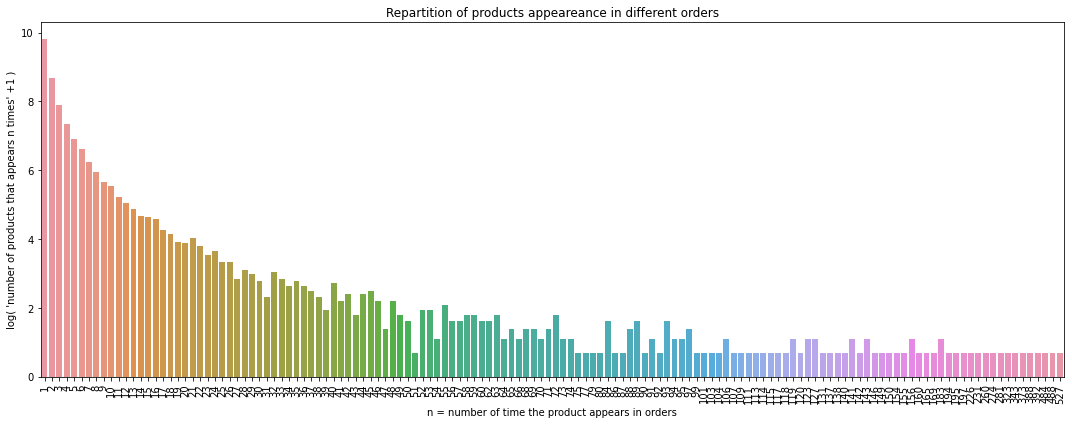

In [55]:
tmp = order_items.product_id.value_counts().value_counts()
plt.figure(figsize=(15,6))
sns.barplot(x=tmp.index, y=np.log(tmp.values+1))
plt.xticks(rotation=90)
plt.title("Repartition of products appeareance in different orders")
plt.xlabel("n = number of time the product appears in orders")
plt.ylabel("log( 'number of products that appears n times' +1 )")
plt.tight_layout()
plt.show()

## some descriptive statistics
n_max = 150 
nb_products_more_than_n = tmp[tmp.index>n_max].cumsum()[-1:].values[0]
percent_products_more_than = np.round(nb_products_more_than_n/
                                      np.unique(order_items.product_id).shape[0]*100,2)
products_more_than_n = order_items.product_id.iloc[np.where(order_items.product_id.value_counts()>n_max)]
nb_appearance_products_more_than = order_items[order_items.product_id.isin(products_more_than_n)].shape[0]


n_min = 4
nb_products_less_than_n = tmp[tmp.index<n_min].cumsum()[-1:].values[0]
percent_products_less_than = np.round(nb_products_less_than_n/
                                      np.unique(order_items.product_id).shape[0]*100,2)

n_min2 = 2
nb_products_less_than_n2 = tmp[tmp.index<n_min2].cumsum()[-1:].values[0]
percent_products_less_than2 = np.round(nb_products_less_than_n2/
                                      np.unique(order_items.product_id).shape[0]*100,2)

Certains produits apparaissent un très grand nombre de fois : 
* {{nb_products_more_than_n}} produits 
( {{ percent_products_more_than }} % des produits) 
apparaissent plus de {{n_max}} fois, ce qui représente
{{ np.round(nb_appearance_products_more_than/order_items.shape[0]*100,1) }} %
des produits commandés

Mais la majorité des produits n'apparait que dans quelques commandes :
* {{nb_products_less_than_n}} produits 
( {{ percent_products_less_than }} % des produits )
apparaissent moins de {{n_min}} fois,
* {{nb_products_less_than_n2}} produits 
( {{ percent_products_less_than2 }} % des produits )
apparaissent moins de {{n_min2}} fois,

Je propose d'ajouter des variables descriptives issues de ces répartitions dans la table "my_products". Cette table sera alors à actualiser régulièrement (tous les 3 mois ? ##TODO : evaluer les temps d'apparition des nouveaux produits, ou changement d'habitude) 

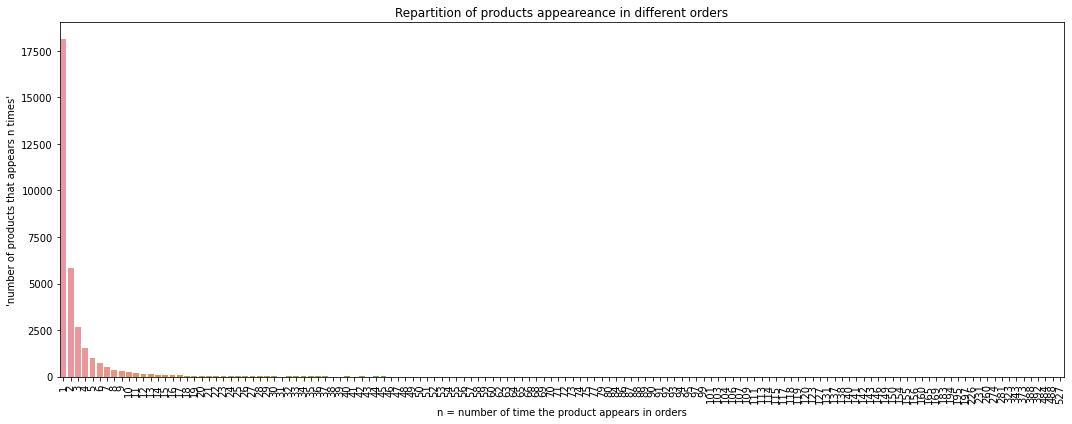

count    32951.000000
mean         3.418713
std         10.619709
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        527.000000
Name: product_id, dtype: float64


In [56]:

tmp = order_items.product_id.value_counts().value_counts()
plt.figure(figsize=(15,6))
sns.barplot(x=tmp.index, y=tmp.values)
plt.xticks(rotation=90)
plt.title("Repartition of products appeareance in different orders")
plt.xlabel("n = number of time the product appears in orders")
plt.ylabel("'number of products that appears n times'")
plt.tight_layout()
plt.show()
product_nb_appearance = order_items.product_id.value_counts()
print(product_nb_appearance.describe())


In [57]:
product_nb_app = order_items.product_id.value_counts()
my_quantile_classes = {"very_low":[1,0.95], "low":[0.95,0.75],
                       "medium_low" : [0.75,0.5],"medium_high" : [0.5,0.25],
                       "high" : [0.25,0.05], "very_high" : [0.05,0]}

## products never on orders : 
my_products.loc[:,"product_freq_buy"] = 0

for freq_class in my_quantile_classes.keys():
    q_max, q_min = my_quantile_classes[freq_class] 
    n_max = product_nb_app.quantile(q=q_max)
    n_min = product_nb_app.quantile(q=q_min)
    if ~(n_min == n_max) : 
        cond_max = np.where(product_nb_app<=n_max)
        cond_min = np.where(product_nb_app>n_min)
        if q_max == 1 :
            range_index = cond_max
        elif q_min == 0 :
            range_index = cond_min
        else :
            range_index = np.intersect1d(cond_min,cond_max)
    
        product_in_class = order_items.product_id.iloc[range_index].values
        my_products.at[product_in_class,"product_freq_buy"] = np.mean([q_min,q_max])
#         my_products.at[product_in_class,"product_freq_buy"] = freq_class

Je mets, dans la table ```my_products``` deux variables drapeau.
La première, "product_flag_ordered_alone" vaut : 
* 0 si le produit n'a jamais été commandé seul
* 1 si le produit a été commandé seul

Et la deuxième, "" prend les valeurs :
* 0 si le produit n'a jamais été commandé 
* 1 si le produit a été commandé au moins une fois

J'y ajoute aussi deux variables "price" qui correspondent au prix moyen et au prix de fret observés sur le produit :

In [58]:
## ordered alone
my_products.loc[:,"product_flag_ordered_alone"] = 0
range_index = np.where(order_items.product_id.value_counts()==1)
products_ordered_alone = order_items.product_id.iloc[range_index].values
products_ordered_alone = my_products.index.isin(products_ordered_alone)
my_products.at[products_ordered_alone,"product_flag_ordered_alone"] = 1
## never ordered
my_products.loc[:,"product_flag_never_ordered"] = 1
range_index = np.where(order_items.product_id.value_counts()>=1)
products_never_ordered = order_items.product_id.iloc[range_index].values
products_never_ordered = my_products.index.isin(products_never_ordered)
my_products.at[products_never_ordered,"product_flag_never_ordered"] = 0

## prices
tmp = order_items.groupby("product_id").mean()[['price', 'freight_value']]
tmp = tmp.add_prefix("product_")
tmp = tmp.reset_index()
my_products = pd.merge(my_products,tmp, on="product_id",how="left")

Ajout d'une colonne correspondant au nonbre de produits dans la commande, dans ma table ```my_order``` : 

In [59]:
tmp = order_items.groupby("order_id").count()["product_id"].reset_index()
tmp = tmp.rename(columns={"product_id":"count_products"})
my_orders = pd.merge(my_orders,tmp, on="order_id",how="left")

Il ne me reste plus qu'à voir s'il est possible de résumer les différentes variable de ```my_products``` avec les catégories des produits (ou un regroupement des catégories).

In [60]:
my_products

,product_id,product_category_name,product_dimension,product_description,product_freq_buy,product_flag_ordered_alone,product_flag_never_ordered,product_price,product_freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,-1.303164,-1.310268,0.000,0,1,10.910000,7.390000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,-0.293717,-1.090214,0.000,0,1,248.000000,17.990000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,-1.244654,-0.997539,0.975,0,0,79.800000,7.820000
3,cef67bcfe19066a932b7673e239eb23d,bebes,-0.676074,-2.077708,0.625,0,0,112.300000,9.540000
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,-0.958274,-0.340106,0.000,0,1,37.900000,8.290000
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,3.026021,-0.861494,0.625,1,0,69.900000,31.103939
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,-0.738382,-0.673972,0.000,0,1,200.000000,17.495000
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,-0.374873,-0.303488,0.625,0,0,127.300000,17.608000
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,-0.463471,0.073953,0.975,1,0,32.702857,19.182857


#### Deuxième tentative de clustering sur les catégories de produit

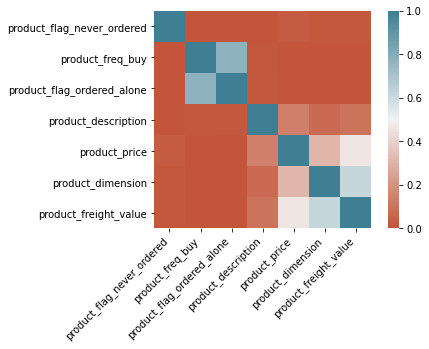

In [61]:
X = get_X_missing_vals_imputed(my_products, std = False)

y = my_products.product_category_name
y = y.fillna("missing")
y = y.astype("category")

plot_heatmap_dist(X.corr())

In [80]:
def frobenius_func(y, y_pred):
    return(np.linalg.norm(y-y_pred,"fro"))

def pseudo_cv_clustering(X_, my_meth, param_grid,my_score, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = 5)
    CV_split_iterator = kf.split(X_) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            if hasattr(my_meth, "fit_transform"): 
                W = my_meth.fit_transform(train)
            else :
                W = my_meth.fit_predict(X=train)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(train, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

In [86]:
from sklearn.cluster import DBSCAN
param_grid = [{ 
             'eps': np.arange(0.1,3, 0.2), 
             'min_samples': np.arange(2,6), 
              }]
my_cls = DBSCAN(n_jobs=5)

# pseudo_cv_reduce_dim(X, my_cls, param_grid,my_score, cv = 5)

my_cls.fit(X)
tmp = my_cls.components_

In [88]:
tmp.shape

(880, 7)

(32951, 7)

In [95]:
pd.Series(my_cls.fit_predict(X)).value_counts()

-1      31377
 8         78
 1         61
 15        46
 5         37
        ...  
 54         5
 149        5
 85         5
 164        4
 137        4
Length: 168, dtype: int64

In [ ]:
## 1st pipe - kmeans
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('cluster', DBSCAN())
    ])
param_grid = [{ 
             'cluster__eps': np.arange(0.1,3, 0.2), 
             'cluster__min_samples': np.arange(2,6), 
              }]
grid = GridSearchCV(pipe1, param_grid = param_grid,
                    n_jobs=5, cv = 5, scoring= "homogeneity_score")
grid.fit(X)

In [ ]:
# ## Save dictionnary of results : 
# res = grid.cv_results_
# with open(res_path+"reduce_dim_products/kmeans_res_my_products"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
# best_params = grid.best_params_
# with open(res_path+"reduce_dim_products/kmeans_best_params_my_products"+".pkl", "wb") as f :
#     pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


# with open(res_path+"reduce_dim_products/kmeans_res_my_products"+".pkl", "rb") as f :
#     res = pickle.load(f)
# with open(res_path+"reduce_dim_products/kmeans_best_params_my_products"+".pkl", "rb") as f :
#     best_params = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()
best_params

In [ ]:
my_orders.dtypes
df = my_orders.copy()
df.select_dtypes(include=['object','datetime64[ns]' ])

## 1.x Lien entre les tables :

In [ ]:
# sellers, products, orders, order_reviews, 
# order_items, geolocation, customers

## customer-order
customer_order = pd.merge(customers[["customer_unique_id","customer_id"]], 
    orders[["customer_id","order_id"]], 
    on = "customer_id", how = 'right')


In [ ]:
customers[["customer_unique_id","customer_id"]]

In [ ]:
dict_log_param = {"reduce_dim__n_components" : False,
                  "reduce_dim__alpha" : False,
                  "reduce_dim__l1_ratio" : False,
                  "classify__n_clusters" : False
                 }

In [ ]:
pca = sklearn.decomposition.PCA(2)
pca.fit(XT)
pca.components_

In [ ]:
X_train, X_test = train_test_split(X, train_size=0.80)
std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [ ]:

def plot_line(x,y,f=1):
    x1 = f*min(x,0)
    x2 = f*max(x,0)
    y1 = f*min(y,0)
    y2 = f*max(y,0)
    print([x1,y1],[x2,y2])
    plt.plot([x1,y1],[x2,y2])
    
X = np.array([[1,1],[3,1],[1,2],[2,0]]).transpose()
XT = X.transpose()


XXT = np.dot(X,XT)
XXT_norm = XXT/np.linalg.norm(XXT)
np.linalg.eig(XXT)

In [ ]:
plt.scatter(XT[:,0],XT[:,1])
# plt.plot([-0.7352,0],[0,0.6779])


plot_line(x = 0, y = 1,f = 1)



In [ ]:
# best_params = {"reduce_dim__alpha": 0.6, "reduce_dim__l1_ratio":0.4, "classify__n_clusters" : 20}
pipe1.set_params(**best_params)
param_grid = [{'reduce_dim__n_components': np.arange(1, X.shape[1]+1)}]

grid = GridSearchCV(pipe1, cv = 5, n_jobs=5, param_grid=param_grid)
grid.fit(X)
# Save dictionnary of results : 
res = grid.cv_results_
with open(res_path+"reduce_dim_products/NMF_kmeans_ncomponent_res"+".pkl", "wb") as f :
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
best_params = grid.best_params_
with open(res_path+"reduce_dim_products/NMF_kmeans_ncomponent_best_params"+".pkl", "wb") as f :
    pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


# with open(res_path+"reduce_dim_products/NMF_kmeans_ncomponent_res"+".pkl", "rb") as f :
#     res = pickle.load(f)
# with open(res_path+"reduce_dim_products/NMF_kmeans_ncomponent_best_params"+".pkl", "rb") as f :
#     best_params = pickle.load(f)

plot_cv_res_pipe(res,dict_log_param)
plt.tight_layout()
best_params